# Evaluate CTSM simulation for runoff
Maps of CTSM runoff compared to GRUN


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import utils
from iv_utils import *
import geopandas as gpd
# plot settings
utils.set_plot_param()


# constants
secperday   = 86400
secperhour  = 3600
dt          = 86400 # time of the modeling can be also hourly for mizuRoute
daypermonth = 30 # average day in a month

### Initialisation

In [24]:
### Initialisation

# model directory
outdir = '/glade/scratch/ivanderk/'

# current working directory
scriptsdir = '/glade/u/home/ivanderk/pp_scripts_mizuroute/'

# Define directory where processing is done -- subject to change
procdir =  '/glade/work/ivanderk/data/'

# mizuroute input dir (to save netcdf file to)
mizuroute_dir = '/glade/work/ivanderk/mizuRoute_global/route/'

# obs dir 
obsdir = '/glade/work/ivanderk/data/'

# go to processing directory 

In [3]:
# set case name
case ='i.IHistClm50Sp.hcru_hcru.CTL'

# run settings -- change this to terms directly? 
block = 'lnd'  # lnd data
               # atm data
               # rof data
   
    
# define start and end year
nspinupyears = 5
spstartyear = '1966'   # spin up start year 
startyear   = str(int(spstartyear)+nspinupyears)   # start year, spin up excluded (5 years for now, best change to 10 when simulation is ready)
endyear     = '2000'   # last year of the simulation


# open network topology 
ntopo = xr.open_dataset(mizuroute_dir+'ancillary_data/ntopo_hdma_mod.reorder_lake_H06.nc')


## 0. Load res obs locations

In [4]:
df_meta = pd.read_csv('/glade/u/home/ivanderk/pp_scritps_mizuroute/lake_models_python/Hanasaki/observations/reservoirs_metadata.csv')
df_meta = df_meta.loc[df_meta['pfaf_hdma_10km'].notnull()]
names = df_meta['name'].values
names = np.delete(names,np.where(names=='Fort_randall'))
res_pfafs = df_meta.loc[df_meta['name'].isin(names),'pfaf_hdma_10km'].values

mask_stations = ntopo.PFAF.astype(int).isin(res_pfafs.astype(int))

df_stations = ntopo[['start_x','start_y','PFAF']].where(mask_stations, drop=True).to_dataframe()
gdf_stations = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations.start_x, df_stations.start_y))
gdf_stations['PFAF'] = gdf_stations['PFAF'].astype(float)
gdf_stations = gdf_stations.merge(df_meta, left_on='PFAF', right_on='pfaf_hdma_10km', how='inner')


In [5]:
gdf_stations= gdf_stations[gdf_stations.name != 'Bennet']
gdf_stations= gdf_stations[gdf_stations.name != 'Dickson']


In [6]:
# load DAHITI obs

gdf_dahiti_ntopo_used = gpd.read_file(obsdir+'DAHITI/DAHITI_stations_used.shp')


## 1. Load CTSM simulation

In [7]:
# user settings
stream = 'h0'  # h0 output block
               # h1 output block
               # h2 output block

exclude_spinup = True

variables =  ['QRUNOFF'] 

In [8]:
fn = 'i.IHistClm50Sp.hcru_hcru.CTL.clm2.h1.'+startyear+'-'+endyear+'.nc'
#fn = 'i.IHistClm50Sp.hcru_hcru.CTL.clm2.h1.ymonmean.nc'
ds= xr.open_dataset(mizuroute_dir+'input/'+fn)

In [9]:
da = ds.QRUNOFF * secperday ## in mm/day
#values = np.roll(da.values,360, axis=2) 

#da_roll = xr.DataArray(values, coords={'time':da.time.values,'lat': da.lat.values, 'lon':  da.lon.values},
             #dims=['time','lat', 'lon'])

#da_roll['lon']  = da_roll['lon']-180


## 2. Load observations

In [10]:
# load observations
ds_obs = xr.open_dataset(obsdir+'grun/GRUN_ensemble_clmgrid_1971-2000.nc')
obs=ds_obs['QRUNOFF']
obs = obs.sel(time=slice(startyear+"-01-01", endyear+"-12-31"))

obs_mean = obs.mean('time')  #mm/day


In [11]:

# plot global map of difference 
def plot_delta_map(da_delta, plot_regions=False, vlims=False, calcsum=False, cmap='BrBG'):
    
    # calculate annual sum instead of mean (precip)
    if calcsum: 
        da_delta_ysum = da_delta.groupby('time.year').sum()
        da_delta_mean = da_delta_ysum.mean('year')
        da_delta_mean.attrs['units'] = 'mm/year'
    # only one value
    elif len(da_delta.dims) < 3: 
        da_delta_mean = da_delta
    # annual means already taken
    elif len(da_delta) < 50:
        da_delta_mean = da_delta.mean('year')
    else:
        da_delta_mean = da_delta.mean('time')
    
    fig = plt.figure(figsize=(30,12))
    proj=ccrs.PlateCarree()
    ax = plt.subplot(111, projection=proj, frameon=False)
        
    # limiting values for plotting are given    
    if vlims==False: 
        da_delta_mean.plot(ax=ax, cmap=cmap, cbar_kwargs={'label': da_delta.name+' ('+da_delta.units+')', 'fraction': 0.02, 'pad': 0.04})
    else: 
        im = da_delta_mean.plot(ax=ax, cmap=cmap, vmin=vlims[0], vmax=vlims[1], extend='both', add_colorbar=False, add_labels=False)
        cb = plt.colorbar(im,fraction= 0.02, pad= 0.04, extend='both')
        cb.set_label(label = da_delta.units, size=20)
        cb.ax.tick_params(labelsize=20)
        
    ax.set_title(da_delta.long_name, loc='right', fontsize=30)
    ax.coastlines(color='dimgray', linewidth=0.5)
    # exclude Antactica from plot
    ax.set_extent((-180,180,-63,90), crs=proj) 

    if plot_regions: regionmask.defined_regions.srex.plot(ax=ax,add_ocean=False, coastlines=False, add_label=False) #label='abbrev'
    return fig, ax


# plot CONUS map of difference 
def plot_delta_map_conus(da_delta, plot_regions=False, vlims=False, calcsum=False, cmap='BrBG'):
    
    # calculate annual sum instead of mean (precip)
    if calcsum: 
        da_delta_ysum = da_delta.groupby('time.year').sum()
        da_delta_mean = da_delta_ysum.mean('year')
        da_delta_mean.attrs['units'] = 'mm/year'
    # only one value
    elif len(da_delta.dims) < 3: 
        da_delta_mean = da_delta
    # annual means already taken
    elif len(da_delta) < 50:
        da_delta_mean = da_delta.mean('year')
    else:
        da_delta_mean = da_delta.mean('time')
    
    fig = plt.figure(figsize=(30,15))
    proj=ccrs.PlateCarree()
    ax = plt.subplot(111, projection=proj, frameon=False)
        
    # limiting values for plotting are given    
    if vlims==False: 
        da_delta_mean.plot(ax=ax, cmap=cmap, cbar_kwargs={'label': da_delta.name+' ('+da_delta.units+')', 'fraction': 0.02, 'pad': 0.04})
    else: 
        im = da_delta_mean.plot(ax=ax, cmap=cmap, vmin=vlims[0], vmax=vlims[1], extend='both', add_colorbar=False, add_labels=False)
        cb = plt.colorbar(im, fraction= 0.04,pad= 0.04, extend='both', orientation='horizontal')
        cb.set_label(label = da_delta.units, size=20)
        cb.ax.tick_params(labelsize=20)
    ax.set_title(da_delta.long_name, loc='right', fontsize=30)
    ax.coastlines(color='dimgray', linewidth=0.5)
    # exclude Antactica from plot
    ax.set_extent([-140,-80,20,80],  crs=proj) 
    ax.text(0, 1.01, 'a.', color='dimgrey', fontsize=25, transform=ax.transAxes );


    if plot_regions: regionmask.defined_regions.srex.plot(ax=ax,add_ocean=False, coastlines=False, add_label=False) #label='abbrev'
    return fig, ax

In [12]:
# caluculate annual mean QRUNOFF
da_roll = da
mod_mean = da_roll.mean('time') 


mod_mean.attrs['units'] = 'mm/day'
mod_mean.attrs['long_name'] = 'Runoff (CTSM)'
mod_mean.name = 'runoff'

#plot_delta_map(mod_mean, plot_regions=False, vlims=[0,10], cmap='Blues');


In [13]:
delta_mean = mod_mean- obs_mean

delta_mean.attrs['units'] = 'mm/day'
delta_mean.attrs['long_name'] = 'Mean Runoff Bias  (CTSM-GRUN)'
delta_mean.name = 'Runoff bias'

In [1]:
fig, ax = plot_delta_map(delta_mean, plot_regions=False, vlims=[-3,3], cmap='RdBu');
gdf_stations.plot(ax=ax, markersize=30, color='black', edgecolor='black',label='reservoir observations');
#gdf_dahiti_ntopo_used.plot(ax=ax, markersize=50, color='darkolivegreen',marker = "^", edgecolor='darkolivegreen', label='DAHITI observations');
gl = ax.gridlines(draw_labels=True, color='lightgray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

#gl.xlines = False
#gl.ylines = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

fig.savefig(procdir+'runoffbias.png', bbox_inches="tight")


NameError: name 'plot_delta_map' is not defined

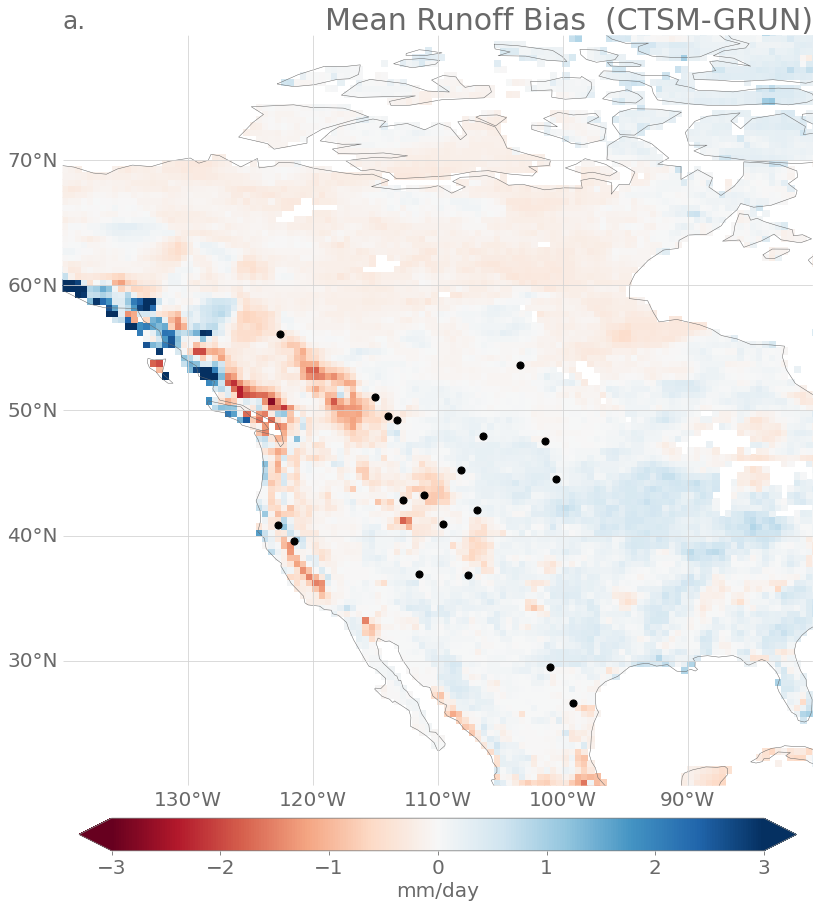

In [30]:
fig, ax = plot_delta_map_conus(delta_mean, plot_regions=False, vlims=[-3,3], cmap='RdBu');
ax = gdf_stations.plot(ax=ax, markersize=50, color='black', edgecolor='black');
gl = ax.gridlines(draw_labels=True, color='lightgray')
gl.top_labels = False
gl.right_labels = False

#gl.xlines = False
#gl.ylines = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

fig.savefig('runoffbias_conus_map.png', bbox_inches="tight")
